In [1]:
import sys
import scipy.io as sio
sys.path.append('../core/')
sys.path.append('../networks/')
#from ssl_fc import *
#from ssl_conv import *
from m2 import SSL_M2
#from vaegan_fc_svhn import *
from cvaegan_conv import *
from cvaegan import CVAEGAN
#from vaegan import VAEGAN
from misc_ops import *

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from dataset import DataSet
from tensorflow.python.framework import dtypes

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def mat2dataset(filepath):
    dat = sio.loadmat(filepath)
    x = dat['X']
    y = dat['y']
    y[y==10] = 0
    y = np.array(np.arange(10)==y, dtype=int)
    x = x.reshape((32*32*3,-1)).T
    x = x.astype(float)/255.
    return DataSet(x,y,dtype=dtypes.float32, reshape=False)

In [3]:
svhn_train = mat2dataset('SVHN/train_32x32.mat')
svhn_test = mat2dataset('SVHN/test_32x32.mat')
#svhn_extra = mat2dataset('SVHN/extra_32x32.mat')

In [4]:
svhn_train.num_examples

73257

In [11]:
def split_data(dataset, num_labeled):
    """
    Split dataset into two datasets
    """
    n = dataset.num_examples
    x, y = dataset.next_batch(n)
    x1 = x[xrange(num_labeled),:]
    y1 = y[xrange(num_labeled),:]
    x2 = x[xrange(num_labeled, n),:]
    y2 = y[xrange(num_labeled, n),:]
    d1 = DataSet(x1, y1, dtype=dtypes.float32, reshape=False)
    d2 = DataSet(x2, y2, dtype=dtypes.float32, reshape=False)
    return d1, d2

In [12]:
# Split dataset into labeled and unlabeled
num_labeled = 7000
labeled, unlabeled = split_data(svhn_train, num_labeled)
_, y = labeled.next_batch(num_labeled)
print np.sum(y, axis=0)

[ 489 1352  983  804  745  667  527  503  494  436]


#  (C)VAEGAN

In [9]:
tf.reset_default_graph()

In [7]:
#Train
sess = tf.InteractiveSession()
build_encoder = Encoder(512)
build_decoder = Decoder(512)
build_discriminator = Discriminator(1024)
model = CVAEGAN(sess, build_encoder, build_decoder, build_discriminator,
               checkpoint_name='cvaegan_svhn_conv', dataset=svhn_train, 
               learning_rate=5e-4, lr_decay=1., num_epochs=5, x_dim=32*32*3,z_dim=100, x_width=32,
              gamma=1.
              )

In [8]:
model.train()

Epoch 1 loss: 1996.13493584 (time: 1195.62322021 s)


KeyboardInterrupt: 

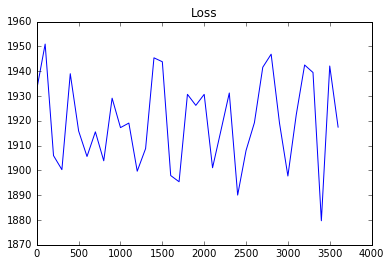

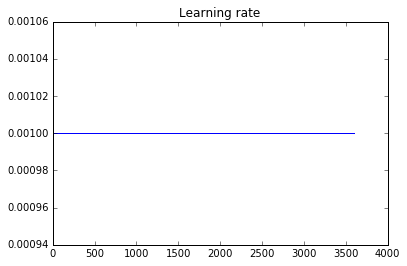

In [191]:
log = model.log
log = np.array(log).T
plt.plot(log[0,], log[1,])
plt.title('Loss')
plt.show()
plt.plot(log[0,], log[2,])
plt.title('Learning rate')
plt.show()

In [5]:
#Load
tf.reset_default_graph()
sess = tf.InteractiveSession()
build_encoder = Encoder(512)
build_decoder = Decoder(512)
build_discriminator = Discriminator(1024)
model = CVAEGAN(sess, build_encoder, build_decoder, build_discriminator,
               checkpoint_name='cvaegan_svhn', dataset=svhn_train,
               learning_rate=1e-3, lr_decay=1., num_epochs=5, x_dim=32*32*3, z_dim=100, x_width=32,
              gamma=1., load=True, load_file='checkpoints/cvaegan_svhn_conv_good3'
              )

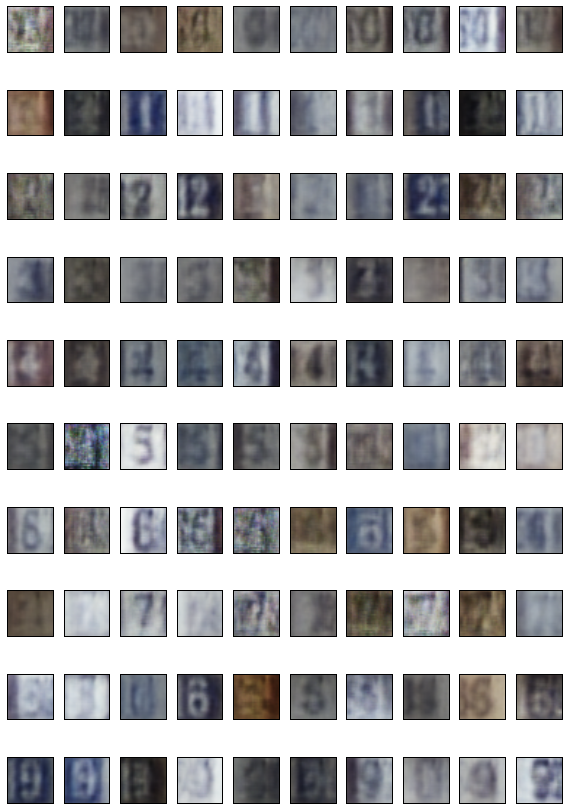

In [6]:
#images, info = mnist.test.next_batch(100)
num_examples = 10
batch_size = 100

# VAEGAN
#generated_images = model.generate(num=batch_size)

# CVAEGAN 
labels = np.repeat(np.identity(10), 10, axis=0)
generated_images = model.generate(num=batch_size, info=labels)


plt.figure(figsize=(8,12))
for i in xrange(10):
    for j in xrange(num_examples):
        plt.subplot(10, num_examples, 10*i+j+1)
        plt.imshow(generated_images[10*i+j,].reshape(32,32,3))
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
#plt.savefig('images/svhn_cvaegan_fc_gen')
plt.show()

In [7]:
testx = svhn_test.images[xrange(100)]
testy = svhn_test.labels[xrange(100)]
mu, log_sigma2 = sess.run([model.z_mean, model.z_log_sigma2],
                         feed_dict = {model.x: testx, model.y: testy})

generated_images = np.zeros((10, 100, 32*32*3))
for j in xrange(10):
    info = np.repeat(np.identity(10)[j,].reshape(1,-1), 100, axis=0) # hack for repeating label j
    generated_images[j,:,:] = sess.run(model.x_mean,
                                      feed_dict = {model.eps : np.random.randn(100, 100),
                                                  model.y: info,
                                                  model.z_mean: mu,
                                                  model.z_log_sigma2: log_sigma2})

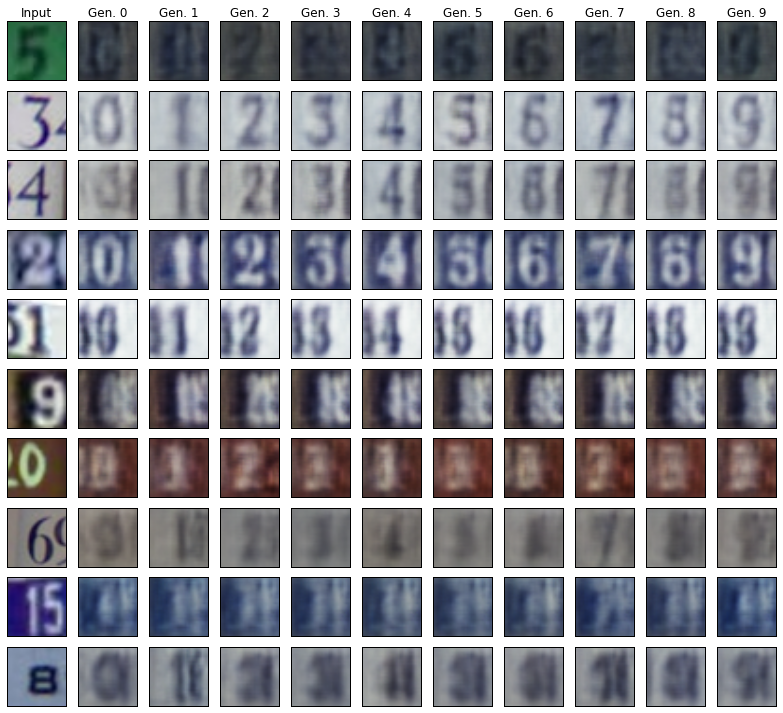

In [17]:
#subset = xrange(50,60)
subset = [0,18,19, 20, 37, 43, 48, 49, 51,55]
#subset = [0,1,2,3,10,13,14,15, 19, 21,23,24,25]
testx_subset = testx[subset]
generated_images_subset = generated_images[:, subset, :]

plt.figure(figsize=(11,len(subset)))
#plt.figure(figsize=(len(subset),11))
for i in xrange(len(subset)):
    plt.subplot(len(subset), 11, 11*i+1)
    plt.imshow(testx_subset[i].reshape(32,32,3), cmap='gray_r')
    if i == 0:
        plt.title('Input')
    plt.xticks([])
    plt.yticks([])
    for j in xrange(10):
        plt.subplot(len(subset),11, 11*i+j+2)
        plt.imshow(generated_images_subset[j,i,:].reshape(32,32,3), cmap='gray_r')
        if i == 0:
            plt.title('Gen. {}'.format(j))
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
#plt.savefig('images/svhn_cvaegan_fc_style')
plt.show()

#  SSL

In [37]:
tf.reset_default_graph()

In [38]:
# Train
sess = tf.InteractiveSession()
build_encoder1 = SSL_Encoder1()
build_encoder2 = SSL_Encoder2(1024)
build_decoder = SSL_Decoder()

# as the number of labeled examples decreases, need alpha to decrease as well?
model = SSL_M2(sess, build_encoder1, build_encoder2, build_decoder, labeled, unlabeled,
            batch_size = 100, z_dim = 256, x_dim = 32*32*3, y_dim=10, alpha=70000./10,
           learning_rate = 5e-4, num_epochs = 10, load=False,
          checkpoint_name='svhn_ssl_fc_7000', x_width=32
)

In [39]:
model.train()

Epoch 1 loss: 18780.0415473 (time: 693.038446188 s)
Epoch 2 loss: 20714.6571932 (time: 687.568762064 s)
Epoch 3 loss: 20175.1403721 (time: 682.911996841 s)
Epoch 4 loss: 21001.9642343 (time: 678.33424592 s)
Epoch 5 loss: 23237.283793 (time: 682.315505981 s)
Epoch 6 loss: 23203.0270235 (time: 464.905655146 s)


KeyboardInterrupt: 

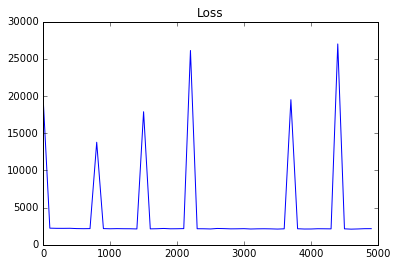

In [40]:
log = model.log
log = np.array(log).T
plt.plot(log[0,], log[1,])
plt.title('Loss')
plt.show()

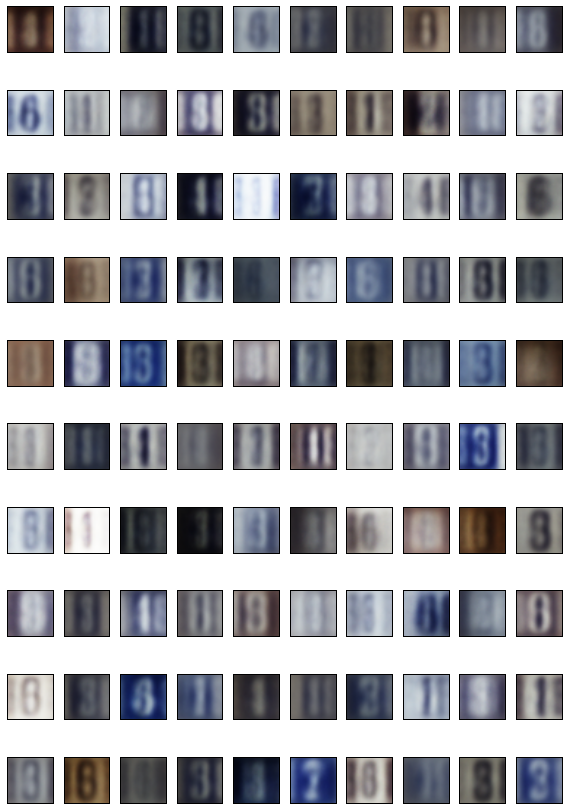

In [41]:
#images, info = mnist.test.next_batch(100)
num_examples = 10
batch_size = 100

labels = np.repeat(np.identity(10), 10, axis=0)
generated_images = model.generate(num=batch_size, labels=labels)


plt.figure(figsize=(8,12))
for i in xrange(10):
    for j in xrange(num_examples):
        plt.subplot(10, num_examples, 10*i+j+1)
        plt.imshow(generated_images[10*i+j,].reshape(32,32,3))
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
#plt.savefig('images/SVHN_generate')
plt.show()

In [42]:
# Classify test images
batch_size = 100
num_test = svhn_test.num_examples
tot = 0
for t in xrange(num_test / batch_size):
    x_test, y_test = svhn_test.next_batch(batch_size)
    y_pred = model.classify(x_test)
    y_test = np.argmax(y_test, axis=1)
    tot += np.sum(y_pred != y_test)
print "Error: {}".format(float(tot)/num_test)
#with open("SSL_errors/SSL_err_500_conv.txt", "w") as text_file:
    #text_file.write("Test error: {}".format(float(tot)/num_test))

Error: 0.829940073755


#  CVAE (left half)

In [73]:
from cvae2 import Conditional_Variational_Autoencoder
from misc_ops import *
from simple_fc import *

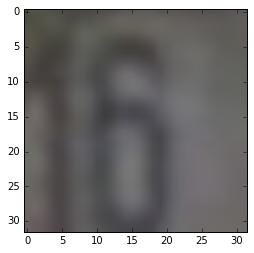

(1, 1536)


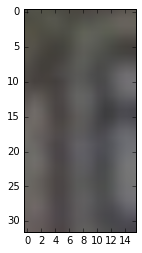

In [74]:
x = svhn_train.images[1000]
plt.imshow(x.reshape(32,32,3))
plt.show()
xmod = get_left_half_depth(x)
print xmod.shape
plt.imshow(xmod.reshape(32,16,3))
plt.show()

In [84]:
tf.reset_default_graph()

In [85]:
# Training
sess = tf.InteractiveSession()
build_encoder = Encoder(512)
build_decoder = Decoder(512)
model = Conditional_Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100,
                                            z_dim = 50,x_dim = 3072,dataset = svhn_train,
                                            learning_rate = 0.001, lr_decay=1., num_epochs = 20, condition_on_label=False,
                                           get_cond_info = get_left_half_depth, cond_info_dim = 32*32*3/2,
                                           checkpoint_name = 'svhn_cvae_left_half_checkpoint')


In [86]:
model.train()

Epoch 1 loss: 1943.34594722 (time: 88.7034959793 s)
Epoch 2 loss: 1896.68713716 (time: 90.604268074 s)
Epoch 3 loss: 1889.74495798 (time: 89.3078389168 s)
Epoch 4 loss: 1886.3431133 (time: 89.8814499378 s)
Epoch 5 loss: 1883.57808867 (time: 83.8727970123 s)
Epoch 6 loss: 1882.77718214 (time: 87.9765708447 s)
Epoch 7 loss: 1882.50377877 (time: 88.9236960411 s)
Epoch 8 loss: 1881.2551193 (time: 88.1498770714 s)
Epoch 9 loss: 1881.10056356 (time: 91.3931941986 s)
Epoch 10 loss: 1880.30978848 (time: 83.1191270351 s)
Epoch 11 loss: 1880.04451696 (time: 57.1467571259 s)
Epoch 12 loss: 1879.50836973 (time: 58.1051011086 s)
Epoch 13 loss: 1879.82162038 (time: 55.5440909863 s)
Epoch 14 loss: 1878.84510503 (time: 92.9741530418 s)
Epoch 15 loss: 1878.95546688 (time: 91.6609840393 s)
Epoch 16 loss: 1878.10592719 (time: 90.886767149 s)
Epoch 17 loss: 1877.61957338 (time: 90.0875229836 s)
Epoch 18 loss: 1877.89312989 (time: 85.3273398876 s)
Epoch 19 loss: 1877.55150015 (time: 93.7867429256 s)
Epoch 

In [ ]:
# Load
sess = tf.InteractiveSession()
build_encoder = Encoder(512)
build_decoder = Decoder(512)
model = Conditional_Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100,
                                            z_dim = 50,x_dim = 3072,dataset = svhn_train,
                                            learning_rate = 0.001, lr_decay=1., num_epochs = 20, condition_on_label=False,
                                           get_cond_info = get_left_half_depth, cond_info_dim = 32*32*3/2,
                                           checkpoint_name = 'svhn_cvae_left_half_checkpoint', load=True, load_file='?')


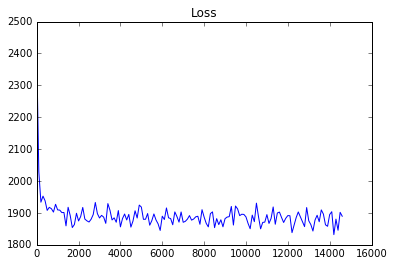

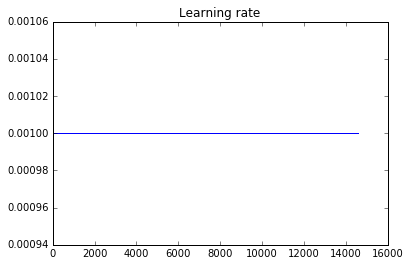

In [87]:
log = model.log
log = np.array(log).T
plt.plot(log[0,], log[1,])
plt.title('Loss')
plt.show()
plt.plot(log[0,], log[2,])
plt.title('Learning rate')
plt.show()

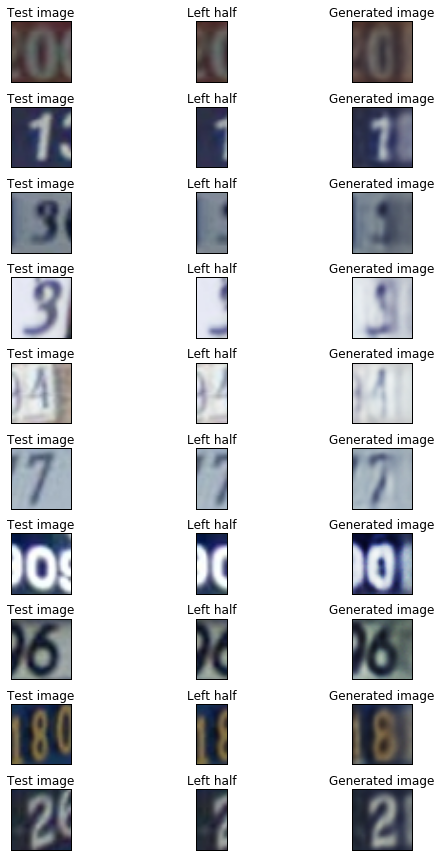

In [107]:
idx = list(range(4))+list(range(8,10))+[21,23, 133, 138]+list(range(230,320))
#idx=range(100)
images = svhn_test.images[idx]
info = get_left_half_depth(images)
generated_images = model.generate(num=100, info=info)

num_show = 10
plt.figure(figsize=(8,12))
for i in xrange(num_show):
    plt.subplot(num_show, 3, 3*i+1)
    plt.imshow(images[i,].reshape(32, 32, 3), cmap='gray_r')
    plt.title('Test image')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(num_show, 3, 3*i+2)
    plt.imshow(info[i,].reshape(32,16,3), cmap='gray_r')
    plt.title('Left half')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(num_show, 3, 3*i+3)
    plt.imshow(generated_images[i,].reshape(32,32,3), cmap='gray_r')
    plt.title('Generated image')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
#plt.savefig('images/svhn_left_half')
plt.show()

# Style

In [108]:
tf.reset_default_graph()

In [109]:
# Training
sess = tf.InteractiveSession()
build_encoder = Encoder(512)
build_decoder = Decoder(512)
model = Conditional_Variational_Autoencoder(sess, build_encoder, build_decoder, batch_size = 100,
                                            z_dim = 50,x_dim = 3072,dataset = svhn_train,
                                            learning_rate = 0.001, lr_decay=1., num_epochs = 20, condition_on_label=True,
                                           cond_info_dim = 10,
                                           checkpoint_name = 'svhn_cvae_label_checkpoint')


In [110]:
model.train()

Epoch 1 loss: 1981.62687028 (time: 67.1265628338 s)
Epoch 2 loss: 1938.89971326 (time: 47.6691789627 s)
Epoch 3 loss: 1928.12786275 (time: 55.5633568764 s)
Epoch 4 loss: 1923.66012481 (time: 60.106744051 s)
Epoch 5 loss: 1918.26691253 (time: 61.1376390457 s)
Epoch 6 loss: 1916.54640799 (time: 59.924888134 s)
Epoch 7 loss: 1915.79959086 (time: 59.9017548561 s)
Epoch 8 loss: 1914.63592853 (time: 60.0291590691 s)
Epoch 9 loss: 1913.30988604 (time: 56.2867951393 s)
Epoch 10 loss: 1912.20098831 (time: 60.3345658779 s)
Epoch 11 loss: 1911.8410426 (time: 59.3663849831 s)
Epoch 12 loss: 1910.9533358 (time: 59.7168629169 s)
Epoch 13 loss: 1911.17910947 (time: 59.2156641483 s)
Epoch 14 loss: 1910.44424392 (time: 59.0432519913 s)
Epoch 15 loss: 1910.41411202 (time: 53.855807066 s)
Epoch 16 loss: 1910.09744306 (time: 60.5642530918 s)
Epoch 17 loss: 1910.14930257 (time: 58.5306229591 s)
Epoch 18 loss: 1909.27679553 (time: 59.1288239956 s)
Epoch 19 loss: 1909.52415134 (time: 59.0141050816 s)
Epoch 2

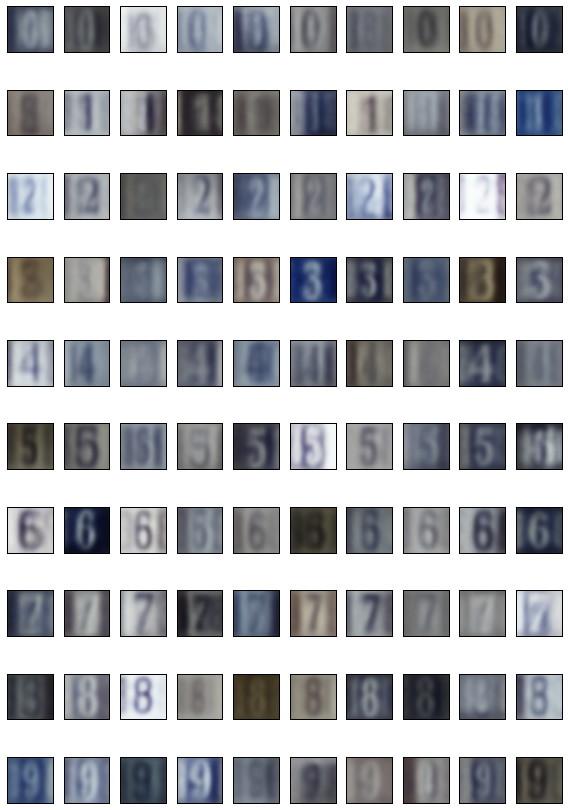

In [113]:
#images, info = mnist.test.next_batch(100)
num_examples = 10

info = np.repeat(np.identity(10), num_examples, axis=0)
generated_images = model.generate(num=100, info=info)

num_show = 5
plt.figure(figsize=(8,12))
for i in xrange(10):
    for j in xrange(num_examples):
        plt.subplot(10, num_examples, 10*i+j+1)
        plt.imshow(generated_images[10*i+j,].reshape(32, 32, 3), cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
#plt.savefig('images/svhn_cvae_fc_label_gen')
plt.show()

In [114]:
testx = svhn_test.images[xrange(100)]
testy = svhn_test.labels[xrange(100)]
mu, log_sigma2 = sess.run([model.encoder_mean, model.encoder_log_sigma2],
                         feed_dict = {model.x: testx, model.y: testy})

generated_images = np.zeros((10, 100, 32*32*3))
for j in xrange(10):
    info = np.repeat(np.identity(10)[j,].reshape(1,-1), 100, axis=0) # hack for repeating label j
    generated_images[j,:,:] = sess.run(model.decoder_mean,
                                      feed_dict = {model.eps : np.random.randn(100, 50),
                                                  model.y: info,
                                                  model.encoder_mean: mu,
                                                  model.encoder_log_sigma2: log_sigma2})

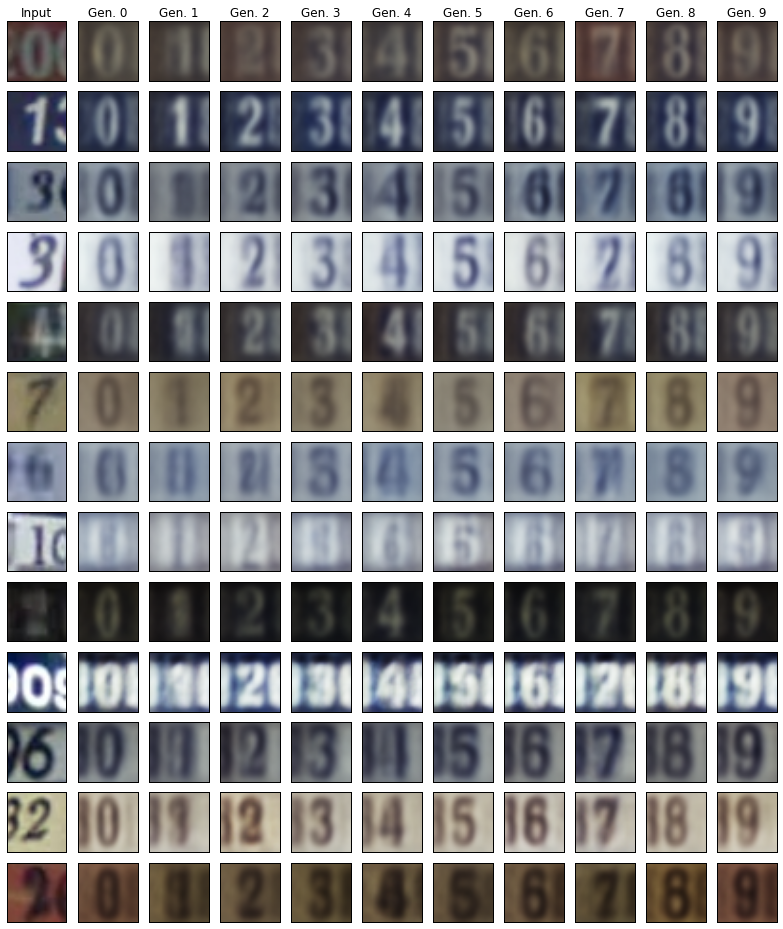

In [123]:
#subset = xrange(20)
subset = [0,1,2,3,10,13,14,15, 19, 21,23,24,25]
testx_subset = testx[subset]
generated_images_subset = generated_images[:, subset, :]

plt.figure(figsize=(11,len(subset)))
#plt.figure(figsize=(len(subset),11))
for i in xrange(len(subset)):
    plt.subplot(len(subset), 11, 11*i+1)
    plt.imshow(testx_subset[i].reshape(32,32,3), cmap='gray_r')
    if i == 0:
        plt.title('Input')
    plt.xticks([])
    plt.yticks([])
    for j in xrange(10):
        plt.subplot(len(subset),11, 11*i+j+2)
        plt.imshow(generated_images_subset[j,i,:].reshape(32,32,3), cmap='gray_r')
        if i == 0:
            plt.title('Gen. {}'.format(j))
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
#plt.savefig('images/svhn_cvae_fc_style')
plt.show()